# Machine learning project - Mikołaj Mazur

In [1]:
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error  # root_mean_squared_error can't import somehow
from matplotlib import pyplot as plt

### Dataset sources

### Model purpose

## Data Exploration

In [2]:
# Chicago Bike Sharing Data

bike_data = pd.read_csv('chicago_bike_sharing_2021.csv')
print(bike_data.head())
print(bike_data.info())

   Unnamed: 0           ride_id  rideable_type           started_at  \
0           0  E19E6F1B8D4C42ED  electric_bike  2021-01-23 16:14:19   
1           1  DC88F20C2C55F27F  electric_bike  2021-01-27 18:43:08   
2           2  EC45C94683FE3F27  electric_bike  2021-01-21 22:35:54   
3           3  4FA453A75AE377DB  electric_bike  2021-01-07 13:31:13   
4           4  BE5E8EB4E7263A0B  electric_bike  2021-01-23 02:24:02   

              ended_at          start_station_name start_station_id  \
0  2021-01-23 16:24:44  California Ave & Cortez St            17660   
1  2021-01-27 18:47:12  California Ave & Cortez St            17660   
2  2021-01-21 22:37:14  California Ave & Cortez St            17660   
3  2021-01-07 13:42:55  California Ave & Cortez St            17660   
4  2021-01-23 02:24:45  California Ave & Cortez St            17660   

  end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
0              NaN            NaN  41.900341 -87.696743    41.89   -8

In [3]:
# Weather data

weather_data = pd.read_csv('weather_data.csv', skiprows=1)
print(weather_data.head())
print(weather_data.info())

         Date  TAVG (Degrees Fahrenheit)  TMAX (Degrees Fahrenheit)  \
0  1928-02-29                        NaN                       39.0   
1  1928-03-01                        NaN                       36.0   
2  1928-03-02                        NaN                       42.0   
3  1928-03-03                        NaN                       37.0   
4  1928-03-04                        NaN                       41.0   

   TMIN (Degrees Fahrenheit)  PRCP (Inches)  SNOW (Inches)  SNWD (Inches)  
0                       27.0            0.0            0.0            0.0  
1                       20.0            0.0            0.0            0.0  
2                       25.0            0.0            0.0            0.0  
3                       15.0            0.0            0.0            0.0  
4                       16.0            0.0            0.0            0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35031 entries, 0 to 35030
Data columns (total 7 columns):
 #   Colu

## Preparation of data - bike dataset

### Remove irrelevant columns

In [4]:
bike_data = bike_data[['started_at']]
bike_data

,started_at
0,2021-01-23 16:14:19
1,2021-01-27 18:43:08
2,2021-01-21 22:35:54
3,2021-01-07 13:31:13
4,2021-01-23 02:24:02
...,...
5595058,2021-12-12 13:36:55
5595059,2021-12-06 19:37:50
5595060,2021-12-02 08:57:04
5595061,2021-12-13 09:00:26


In [5]:
# format date

bike_data['started_at'] = bike_data['started_at'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')
)

In [6]:
bike_data

,started_at
0,2021-01-23
1,2021-01-27
2,2021-01-21
3,2021-01-07
4,2021-01-23
...,...
5595058,2021-12-12
5595059,2021-12-06
5595060,2021-12-02
5595061,2021-12-13


### Group by data

In [7]:
bike_data_count = bike_data.groupby('started_at')['started_at'].count().reset_index(name='Count')
bike_data_count

,started_at,Count
0,2021-01-01,1068
1,2021-01-02,2275
2,2021-01-03,2383
3,2021-01-04,3209
4,2021-01-05,3845
...,...,...
360,2021-12-27,4903
361,2021-12-28,2830
362,2021-12-29,5370
363,2021-12-30,6129


### NaN check

In [8]:
bike_data_count.isna().sum()

started_at    0
Count         0
dtype: int64

### Rename column

In [9]:
bike_data_count = bike_data_count.rename(columns={'started_at': 'Date'})
bike_data_count

,Date,Count
0,2021-01-01,1068
1,2021-01-02,2275
2,2021-01-03,2383
3,2021-01-04,3209
4,2021-01-05,3845
...,...,...
360,2021-12-27,4903
361,2021-12-28,2830
362,2021-12-29,5370
363,2021-12-30,6129


## Preparation of data - weather dataset

### Resolve differences in date range

In [10]:
print(weather_data.columns)

Index(['Date', 'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)',
       'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)',
       'SNWD (Inches)'],
      dtype='object')


In [11]:
print(weather_data['Date'].min())
print(weather_data['Date'].max())

1928-02-29
2024-01-26


### NaN check

In [12]:
weather_data.isna().sum()

Date                             0
TAVG (Degrees Fahrenheit)    35031
TMAX (Degrees Fahrenheit)     1421
TMIN (Degrees Fahrenheit)     1431
PRCP (Inches)                 1422
SNOW (Inches)                 1529
SNWD (Inches)                 1540
dtype: int64

### Merge datasets

In [13]:
print(bike_data_count.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    365 non-null    object
 1   Count   365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB
None


In [14]:
merged_df = pd.merge(bike_data_count, weather_data, on='Date', how = 'inner')
merged_df

,Date,Count,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,2021-01-01,1068,NaN,35.0,24.0,0.31,0.5,1.0
1,2021-01-02,2275,NaN,36.0,30.0,0.00,0.0,1.0
2,2021-01-03,2383,NaN,34.0,27.0,0.05,0.6,1.0
3,2021-01-04,3209,NaN,31.0,25.0,0.00,0.0,1.0
4,2021-01-05,3845,NaN,37.0,29.0,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...
360,2021-12-27,4903,NaN,48.0,34.0,0.27,0.0,0.0
361,2021-12-28,2830,NaN,39.0,33.0,0.27,1.6,1.0
362,2021-12-29,5370,NaN,39.0,32.0,0.02,0.2,0.0
363,2021-12-30,6129,NaN,39.0,33.0,0.00,0.0,0.0


### NaN check

In [15]:
merged_df.isna().sum()

Date                           0
Count                          0
TAVG (Degrees Fahrenheit)    365
TMAX (Degrees Fahrenheit)      0
TMIN (Degrees Fahrenheit)      0
PRCP (Inches)                  0
SNOW (Inches)                  0
SNWD (Inches)                  1
dtype: int64

In [16]:
merged_df = merged_df.drop(columns='TAVG (Degrees Fahrenheit)')

In [17]:
merged_df.isna().sum()

Date                         0
Count                        0
TMAX (Degrees Fahrenheit)    0
TMIN (Degrees Fahrenheit)    0
PRCP (Inches)                0
SNOW (Inches)                0
SNWD (Inches)                1
dtype: int64

In [18]:
merged_df = merged_df.dropna()
merged_df = merged_df.drop(columns='Date')
merged_df

,Count,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,1068,35.0,24.0,0.31,0.5,1.0
1,2275,36.0,30.0,0.00,0.0,1.0
2,2383,34.0,27.0,0.05,0.6,1.0
3,3209,31.0,25.0,0.00,0.0,1.0
4,3845,37.0,29.0,0.00,0.0,1.0
...,...,...,...,...,...,...
360,4903,48.0,34.0,0.27,0.0,0.0
361,2830,39.0,33.0,0.27,1.6,1.0
362,5370,39.0,32.0,0.02,0.2,0.0
363,6129,39.0,33.0,0.00,0.0,0.0


### Feature selection

In [19]:
X = merged_df.drop(columns='Count')
y = merged_df['Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Normalization and standardization

In [20]:
scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

## Constructing regression models

### Model 1 - linear regression

Mean Squared Error : 16762500.025857376
Mean Absolute Error : 3097.0325285019444
Root Mean Squared Error : 4094.203222344657


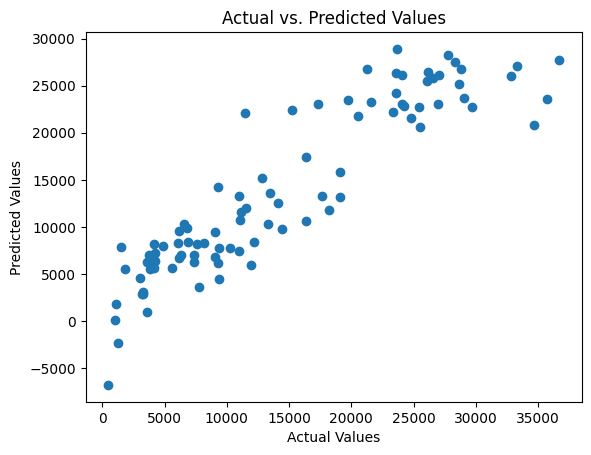

In [21]:
model = LinearRegression().fit(X_train_normalized, y_train)
y_pred = model.predict(X_test_normalized)

# evaluation
print('Mean Squared Error :', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error :', mean_absolute_error(y_test, y_pred))
# print('Root Mean Squared Error :', root_mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error :', mean_squared_error(y_test, y_pred, squared=False))

# plotting
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

### Model 2 - polynomial regression

Mean Squared Error : 85335810.26672983
Mean Absolute Error : 4741.324254512569
Root Mean Squared Error : 9237.738374013947


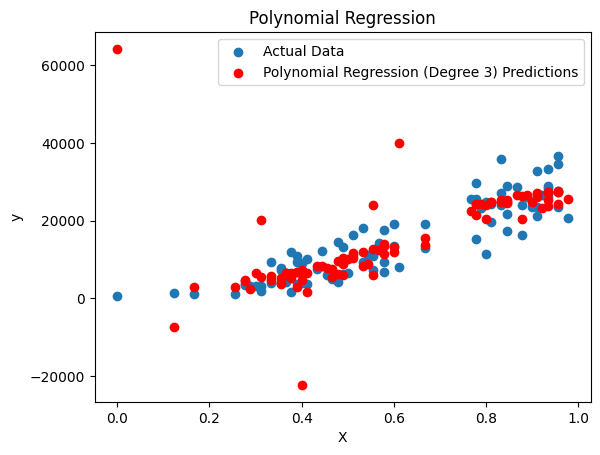

In [22]:
degree = 3
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_normalized)
X_test_poly = poly_features.transform(X_test_normalized)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_poly, y_train)

y_pred_poly = poly_reg_model.predict(X_test_poly)

# evaluation
print('Mean Squared Error :', mean_squared_error(y_test, y_pred_poly))
print('Mean Absolute Error :', mean_absolute_error(y_test, y_pred_poly))
# print('Root Mean Squared Error :', root_mean_squared_error(y_test, y_pred_poly))
print('Root Mean Squared Error :', mean_squared_error(y_test, y_pred_poly, squared=False))

# plotting
sorted_indices = X_test_normalized[:, 0].argsort()
X_test_sorted = X_test_normalized[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]

plt.scatter(X_test_normalized[:, 0], y_test, label='Actual Data')
plt.scatter(X_test_sorted[:, 0], y_pred_poly[sorted_indices], color='red', label=f'Polynomial Regression (Degree {degree}) Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Regression')
plt.legend()
plt.show()